Sentiment Analysis using LSTM

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Import Libraries

In [ ]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text

Data Read and Preprocessing

In [ ]:
link="https://drive.google.com/file/d/1IqD5LxWk0vGSX8Loq-MLqz5gRskNct-N/view?usp=sharing"
link="https://drive.google.com/file/d/1cth3G6X0hu4s00M-1-Mt3Pva5z-M3fsm/view?usp=share_link"
link="https://drive.google.com/file/d/1ropleZgu2UYJp5RYTnkEHGSQgxEztNnv/view?usp=share_link"
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('train.txt')
df_train=pd.read_csv('train.txt', names=['Text', 'Emotion'], sep=';')
downloaded.GetContentFile('test.txt')
df_test=pd.read_csv('test.txt', names=['Text', 'Emotion'], sep=';')
downloaded.GetContentFile('val.txt')
df_val=pd.read_csv('val.txt', names=['Text', 'Emotion'], sep=',')


In [ ]:
df_test = df_test[df_test['Emotion'].isin(['sadness','anger','joy','fear','love','surprise'])]
df_val = df_val[df_val['Emotion'].isin(['sadness','anger','joy','fear','love','surprise'])]
df_train = df_train[df_train['Emotion'].isin(['sadness','anger','joy','fear','love','surprise'])]

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

Data Visualization and Class Counting

In [ ]:
sns.countplot(y_train)
plt.title("Training data - classes counts")
plt.show()

sns.countplot(y_test)
plt.title("Testing data - classes counts")
plt.show()

sns.countplot(y_val)
plt.title("Validation data - classes counts")
plt.show()

ValueError: ignored

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Label Encoding

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

ValueError: ignored

Tokenize Words

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 7106


Embedding

In [ ]:
max_features = 20000
maxlen = 100
embedding_size = 128

Importing the dependancies

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Activation, Flatten, Input, concatenate, Conv1D, GlobalMaxPooling1D, MaxPooling1D

Building the model

In [ ]:
from tensorflow.keras.layers import SimpleRNN
model = Sequential()
model.add(Embedding(vocabSize, embedding_size, input_length=X_train.shape[1]))
model.add(LSTM(128, return_sequences=True)),
model.add(LSTM(128)),
model.add(Dropout(0.2))  ,
model.add(Dense(1024, activation='relu')),
model.add(Dropout(0.2))  ,
model.add(Dense(6))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 256, 128)          909568    
                                                                 
 lstm_2 (LSTM)               (None, 256, 128)          131584    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              132096    
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 6)                

Train the model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=30,
                   )

Epoch 1/30
8/8 [==============================] - 117s 16s/step - loss: 1.6959 - accuracy: 0.3355 - val_loss: 1.5896 - val_accuracy: 0.3351
Epoch 2/30
8/8 [==============================] - 110s 15s/step - loss: 1.5869 - accuracy: 0.3520 - val_loss: 1.5751 - val_accuracy: 0.3351
Epoch 3/30
8/8 [==============================] - 109s 15s/step - loss: 1.5690 - accuracy: 0.3425 - val_loss: 1.5710 - val_accuracy: 0.3351
Epoch 4/30
8/8 [==============================] - 108s 15s/step - loss: 1.5408 - accuracy: 0.3520 - val_loss: 1.5513 - val_accuracy: 0.3351
Epoch 5/30
8/8 [==============================] - 108s 15s/step - loss: 1.4250 - accuracy: 0.3620 - val_loss: 2.2893 - val_accuracy: 0.3356
Epoch 6/30
8/8 [==============================] - 169s 23s/step - loss: 1.4252 - accuracy: 0.3700 - val_loss: 1.5201 - val_accuracy: 0.2993
Epoch 7/30
8/8 [==============================] - 108s 15s/step - loss: 1.2077 - accuracy: 0.4155 - val_loss: 1.4876 - val_accuracy: 0.3783
Epoch 8/30
8/8 [====

Evaluate Accuracy

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

63/63 [==============================] - 19s 303ms/step - loss: 4.4688 - accuracy: 0.5560


[4.468808174133301, 0.5559999942779541]

Plot Accuracy

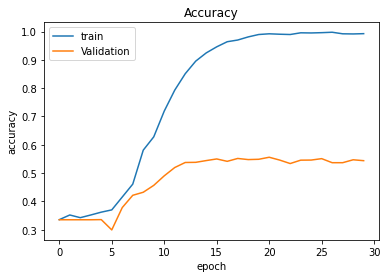

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

Plot Loss

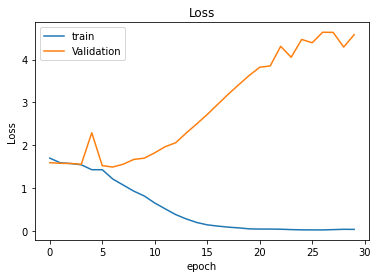

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()